<a href="https://colab.research.google.com/github/yazimi2/data_science/blob/master/stock_price_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [89]:
code = "5238.KL" #@param ["MFST", "TSLA", "AAPL", "5238.KL"] {allow-input: true}

print (code)

5238.KL


In [62]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

In [90]:
#define the ticker symbol
tickerSymbol = code

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
# tickerDf = tickerData.history(period='1d', start='2020-1-1', end='2020-12-12')
tickerDf = tickerData.history(period="max")

#see your data
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-07-10,1.01333,1.02942,1.00529,1.00529,199531394,0,0
2013-07-11,1.01333,1.02137,1.00529,1.02137,36178453,0,0
2013-07-12,1.02137,1.02137,1.00529,1.01333,11046676,0,0
2013-07-15,1.01333,1.01333,1.00529,1.00529,13502059,0,0
2013-07-16,1.00529,1.01333,1.00529,1.00529,13288067,0,0


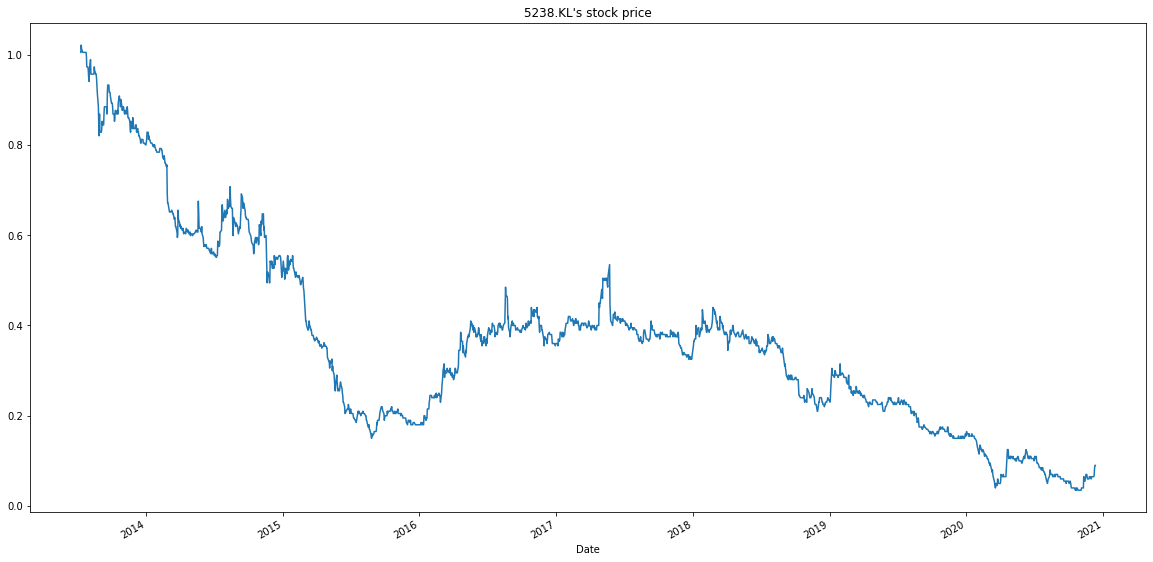

In [91]:
fig = plt.figure(figsize=(20,10))
tickerDf['Close'].plot(title=code+"'s stock price");

In [93]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [143]:
#@title Default title text
split_index = 1500 #@param {type:"slider", min:30, max:1500, step:1}


#creating dataframe
data = tickerDf.sort_index(ascending=True, axis=0).reset_index()
new_data = pd.DataFrame(index=range(0,len(tickerDf)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
split_idx = split_index

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

In [144]:
new_data.head()

,Close
Date,
2013-07-10,1.00529
2013-07-11,1.02137
2013-07-12,1.01333
2013-07-15,1.00529
2013-07-16,1.00529


In [145]:
train = dataset[0:split_idx,:]
valid = dataset[split_idx:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

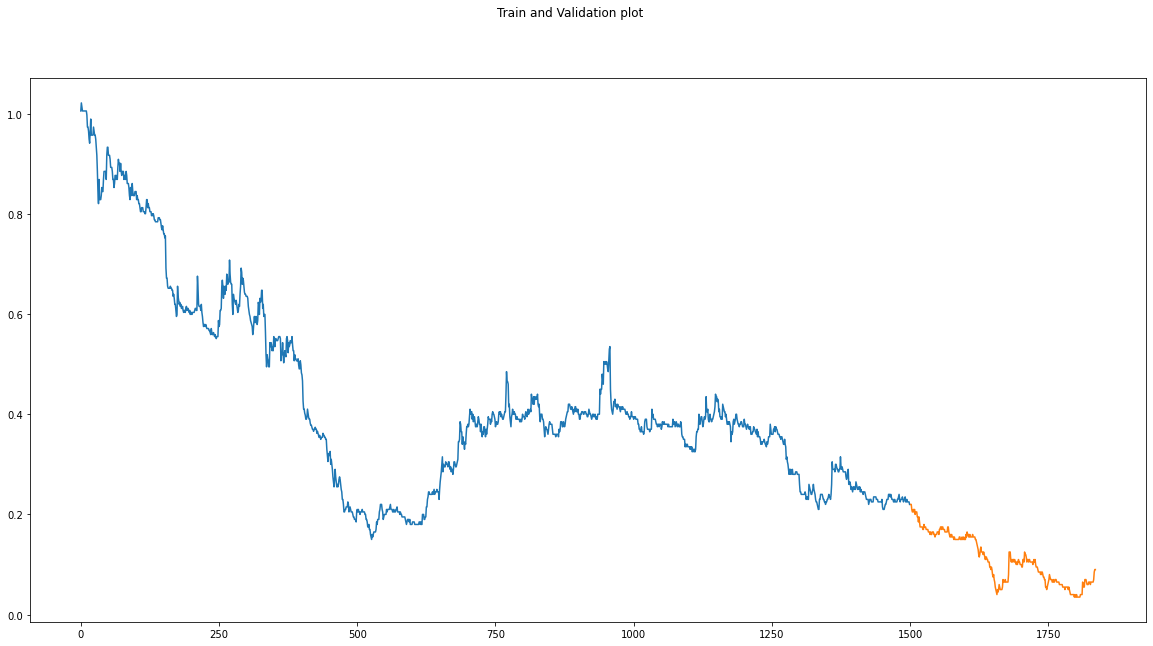

In [146]:
fig = plt.figure(figsize=(20,10))
plt.plot(train);
plt.plot(np.arange(split_idx+1, split_idx+1+len(valid)), valid);
plt.suptitle("Train and Validation plot");

In [147]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

1440/1440 - 30s - loss: 0.0015


In [148]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.02260741238733824

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


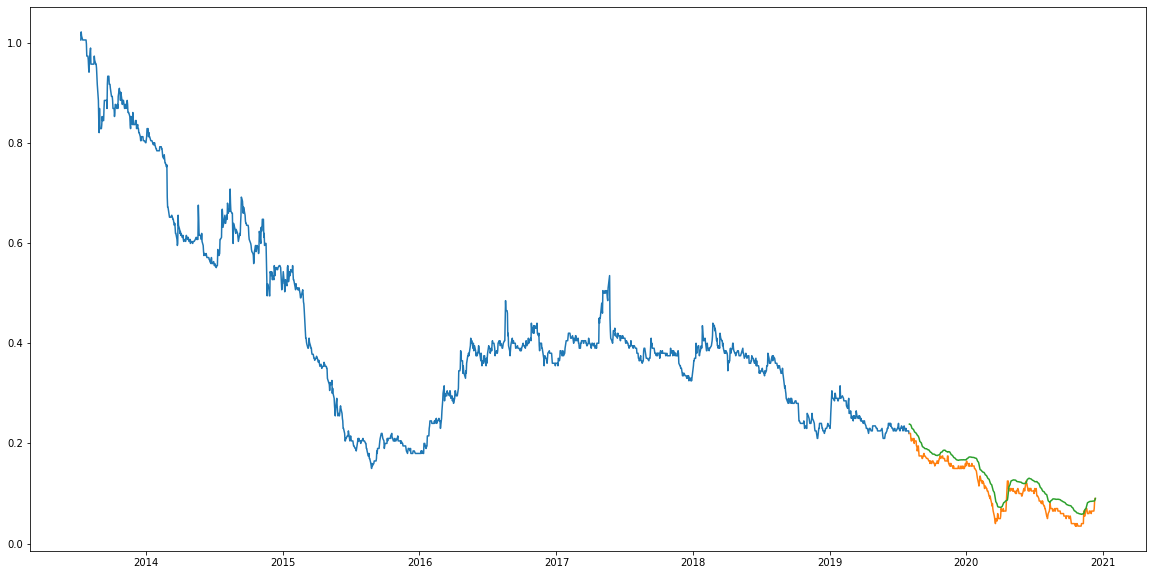

In [149]:
#for plotting
train = new_data.iloc[:split_idx]
valid = new_data.iloc[split_idx:]
valid['Predictions'] = closing_price

fig = plt.figure(figsize=(20,10))
plt.plot(train['Close']);
plt.plot(valid[['Close','Predictions']]);